In [1]:
from get_data import get_data, get_data_train, get_data_val
import torch
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from datasets import InMemDataLoader
import torch.nn.functional as F
import torch
import nibabel as nib     # Read / write access to some common neuroimaging file formats
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
all_paths_alz = []
for root, dirs, files in os.walk(os.path.abspath("/home/ramana44/alziemers_patients/")):
    for file in files:
        #print(os.path.join(root, file))
        all_paths_alz.append((os.path.join(root, file)))
print('len(all_paths_alz)',len(all_paths_alz))


all_paths_norm = []
for root, dirs, files in os.walk(os.path.abspath("/home/ramana44/healthy_control/")):
    for file in files:
        #print(os.path.join(root, file))
        all_paths_norm.append((os.path.join(root, file)))
print('len(all_paths_norm)',len(all_paths_norm))

len(all_paths_alz) 22
len(all_paths_norm) 79


In [3]:

def get_data(paths, device, shuffle=False):
    data = _normalize([_rotate(nib.load(p).get_fdata()) for p in paths])   # load and preprocess all slices from all patients                               
    data_t = torch.FloatTensor(data).to(device)                            # data_t has now the shape: (num_patients, x, y, num_slices)
    data_t = data_t.permute(0, 3, 1, 2)                                    # permute data_t to be in shape (num_patients, num_slices, x, y)
    data_t = data_t[:, 31:32, :, :]
    data_t = data_t.reshape(data_t.shape[0]*data_t.shape[1],               # reduce dim of data_t to have shape (num_patients*num_slices, x, y)
             data_t.shape[2], data_t.shape[3])
    data_t = data_t.unsqueeze(1)                                           # add image channel, data_t now has shape (num_patients*num_slices, num_channel, x, y)
    if shuffle:                                                            # randomly shuffle all slices
        random_indices = torch.randperm(data_t.shape[0])                   # get list of random indices 
        data_t = data_t[random_indices, :, :, :]                           # reorder the set with the random indices
    return data_t

def _normalize(data):
    data = (data - np.min(data))/(np.max(data)-np.min(data))                # normalize data
    return data                     

def _rotate(data):
    data = np.rot90(data)                                                   # rotate by 90°, without rotation the base of the skull is located to the left of the image       
    return data                                                             # with rotation, the base of the skull is located to the bottom of the image


In [4]:
def get_train_test_set(paths, device, batch_size=32, train_set_size=1.0, test_set_size=0.0):
    assert train_set_size + test_set_size <= 1., "Train and test set size should not exceed 100%"
    
    path_indices = np.arange(len(paths))
    #np.random.shuffle(path_indices)                             # randomize indices of the paths for train and test set selection
    
    num_train = int(np.round_(len(paths) * train_set_size))     # calc amount of training sets to load
    num_test = int(np.round_(len(paths) * test_set_size))       # calc amount of test sets to load
    train_indices = path_indices[:num_train]                    # select unique and random indices from all paths
    test_indices = path_indices[-num_test:]   # for train and test set


    train_data = get_data([paths[i] for i in train_indices], device)  # only load specific indices preveiously selected
    test_data = get_data([paths[i] for i in test_indices], device)
    print('train_data.shape',train_data.shape)
    print('test_data.shape',test_data.shape)


    train_loader = InMemDataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True) # init dataloader for train and test set
    test_loader = InMemDataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True) 
    return train_loader, test_loader


    

In [5]:
#alziemers train test loaders
train_loader_alz, test_loader_alz = get_train_test_set(all_paths_alz, device, batch_size=20, train_set_size=1.0)

#normal train test loaders
train_loader_norm, test_loader_norm = get_train_test_set(all_paths_norm, device, batch_size=30, train_set_size=0.4)

train_data.shape torch.Size([22, 1, 96, 96])
test_data.shape torch.Size([22, 1, 96, 96])
train_data.shape torch.Size([32, 1, 96, 96])
test_data.shape torch.Size([79, 1, 96, 96])


In [6]:
batch_x_alz = next(iter(train_loader_alz))

batch_x_norm = next(iter(train_loader_norm))

print('batch_x_alz.shape',batch_x_alz.shape)
print('batch_x_norm.shape',batch_x_norm.shape)

batch_x_alz.shape torch.Size([20, 1, 96, 96])
batch_x_norm.shape torch.Size([30, 1, 96, 96])


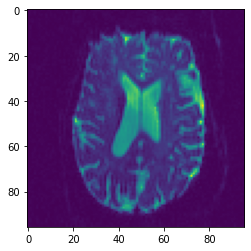

In [7]:
plt.imshow(batch_x_alz[5].squeeze(0).detach().cpu().numpy())

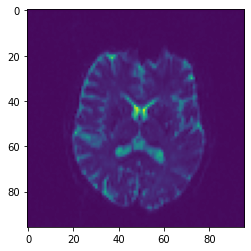

In [8]:
plt.imshow(batch_x_norm[3].squeeze(0).detach().cpu().numpy())

In [8]:
#combining healthy and alzimers into a single batch. healthy batch stacked on alziemers

batch_x_all = torch.cat((batch_x_alz ,batch_x_norm),0)
batch_x_all.shape

torch.Size([50, 1, 96, 96])

In [9]:
def plot_images(images):
    w = 12
    h = 12
    fig = plt.figure(figsize=(10, 10))
    columns = 5
    rows = 4
    for i in range(1, columns*rows +1):
        img = images[i-1][0].detach().cpu().numpy()
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.colorbar()
        plt.axis('off')
    plt.show()

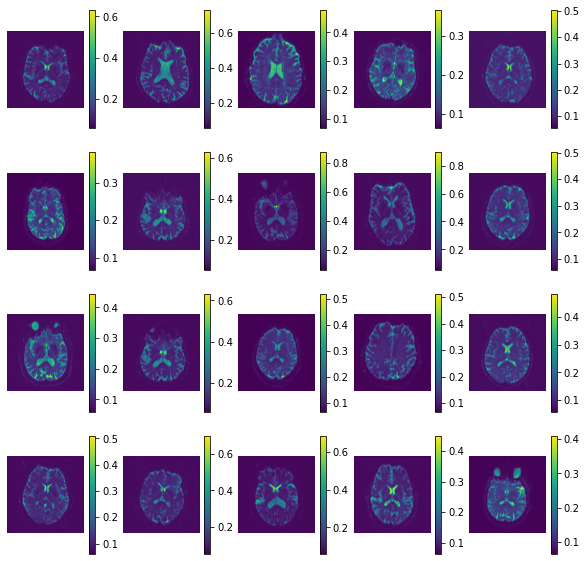

In [10]:
plot_images(batch_x_all[20:40])

In [37]:
# load trained rAE and bAE
from models import AE
from activations import Sin

path = '/home/ramana44/oasis_mri_2d_slices_PH_in_lat_spc/output/MRT_full/test_run_saving/'
#specify hyperparameters
reg_nodes_sampling = 'legendre'
alpha = 0.0001
frac = 0.8
hidden_size = 1000
deg_poly = 20
latent_dim = 80
lr = 0.0001
no_layers = 5

name = '_'+reg_nodes_sampling+'_'+str(frac)+'_'+str(alpha)+'_'+str(hidden_size)+'_'+str(deg_poly)+'_'+str(latent_dim)+'_'+str(lr)+'_'+str(no_layers)

no_channels, dx, dy = (train_loader_alz.dataset.__getitem__(1).shape)
inp_dim = [no_channels, dx, dy]
model_reg = AE(inp_dim, hidden_size, latent_dim, no_layers, Sin()).to(device)
model_base = AE(inp_dim, hidden_size, latent_dim, no_layers, Sin()).to(device)

#model_reg.load_state_dict(torch.load(path+'model_reg'+name, map_location=torch.device('cpu'))["model"])
#model_base.load_state_dict(torch.load(path+'model_reg'+name, map_location=torch.device('cpu'))["model"])

model_reg.load_state_dict(torch.load(path+'model_reg'+name, map_location=torch.device('cpu')))
model_base.load_state_dict(torch.load(path+'model_base'+name, map_location=torch.device('cpu')))
#model_reg.eval()
#model_base.eval()

<All keys matched successfully>

In [38]:
# cleaning and normalizing
batch_x_all[np.where(batch_x_all < 0)] = 0

batch_x_all = batch_x_all / batch_x_all.max()

#encoding using the baseline model
lat_space_baseline = model_base.encoder(batch_x_all)#.view(batch_x_all.shape)

#encoding using the baseline model
lat_space_aereg = model_reg.encoder(batch_x_all)#.view(batch_x_all.shape)
lat_space_aereg.shape


torch.Size([50, 80])

In [39]:
rec_rAE = model_reg(batch_x_all).view(batch_x_all.shape)
rec_bAE = model_base(batch_x_all).view(batch_x_all.shape)

In [40]:
rec_rAE.shape

torch.Size([50, 1, 96, 96])

In [41]:
rec_bAE.shape

torch.Size([50, 1, 96, 96])

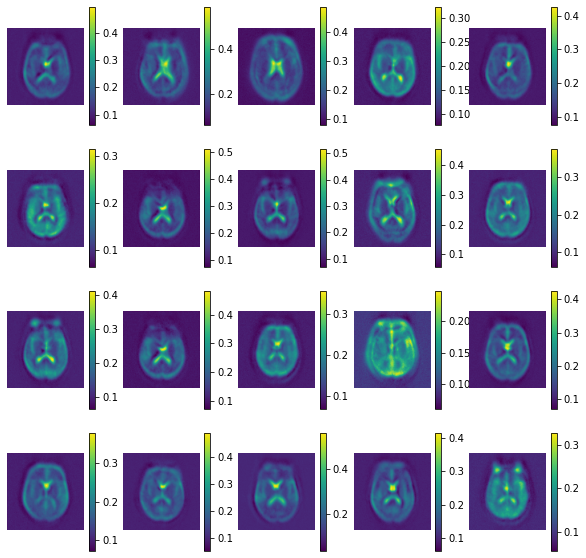

In [42]:
plot_images(rec_rAE[20:40])

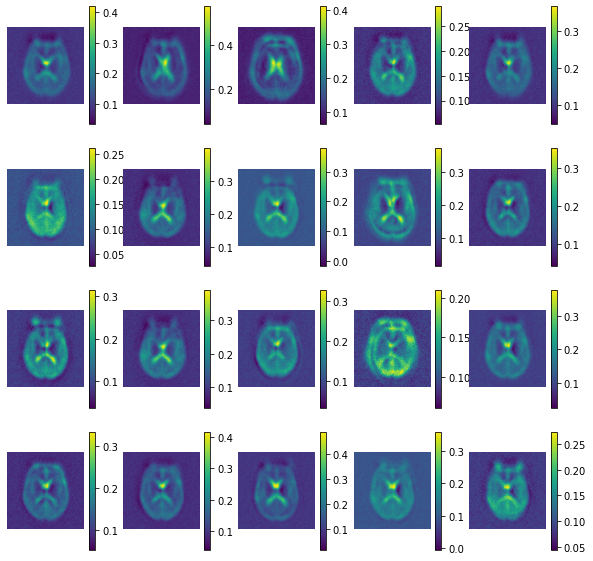

In [43]:
plot_images(rec_bAE[20:40])

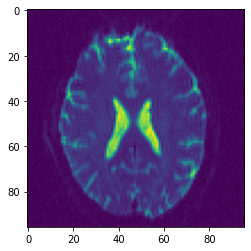

In [44]:
plt.imshow(batch_x_all[0].squeeze(0))

In [45]:
rec_bAE[0].shape

torch.Size([1, 96, 96])

In [51]:
#calculating the wasserstein distance of baseline and regularized images with the original images

import ot

image_index = 0

In [52]:
wassDistance_base = ot.sliced_wasserstein_distance(batch_x_all[image_index].squeeze(0), rec_bAE[image_index].squeeze(0), seed=0)  

wassDistance_base

tensor(0.0217, grad_fn=<PowBackward0>)

In [53]:
wassDistance_reg = ot.sliced_wasserstein_distance(batch_x_all[image_index].squeeze(0), rec_rAE[image_index].squeeze(0), seed=0)  

wassDistance_reg

tensor(0.0238, grad_fn=<PowBackward0>)

In [54]:
wassDistance_base_l2 = torch.mean(torch.sqrt(torch.square(batch_x_all[image_index] - rec_bAE[image_index])))  
wassDistance_base_l2

tensor(0.0260, grad_fn=<MeanBackward0>)

In [55]:
wassDistance_reg_l2 = torch.mean(torch.sqrt(torch.square(batch_x_all[image_index] - rec_rAE[image_index])))  
wassDistance_reg_l2

tensor(0.0270, grad_fn=<MeanBackward0>)

In [15]:
#Now get distance matrix

def _compute_distance_matrix(x, p=2):
    x_flat = x.view(x.size(0), -1)

    distances = torch.norm(x_flat[:, None] - x_flat, dim=2, p=p)

    return distances

In [16]:

dist_matrx = _compute_distance_matrix(lat_space_baseline, p=2)

In [17]:
dist_matrx[0]

tensor([0.0000, 2.6532, 2.6408, 3.4467, 2.6160, 2.6893, 2.4310, 2.6529, 2.7623,
        2.6323, 1.9953, 0.6912, 2.6351, 2.6426, 1.8420, 2.5489, 2.4752, 2.4683,
        2.3679, 2.5444, 2.1720, 2.3608, 2.1810, 2.1258, 2.1473, 2.2757, 3.0090,
        2.7840, 2.0373, 2.7177, 2.4407, 2.3635, 2.4070, 2.4435, 2.6550, 2.2943,
        2.1187, 2.4735, 2.4608, 2.7018, 2.4357, 2.4584, 2.8362, 2.6835, 2.2150,
        2.1856, 2.0096, 2.1566, 2.5188, 2.3369], grad_fn=<SelectBackward0>)

In [18]:
import ot

In [19]:
batch_x_all[0] = batch_x_all[0]/torch.max(batch_x_all[0])
batch_x_all[0].shape

torch.Size([1, 96, 96])

In [20]:
#Computing wasserstein distance matrix

wass_dist_matrix = np.zeros((lat_space_baseline.shape[0], lat_space_baseline.shape[0]))
for i in range(lat_space_baseline.shape[0]):
    for j in range(lat_space_baseline.shape[0]):
        if(i==j):
            wass_dist_matrix[j, i] = 0
        else:
            lat_space_baseline_i = lat_space_baseline[i]/torch.sum(lat_space_baseline[i])
            lat_space_baseline_j = lat_space_baseline[j]/torch.sum(lat_space_baseline[j])
            #print('lat_space_baseline_i.shape',lat_space_baseline_i.shape)
            #print('lat_space_baseline_j.shape',lat_space_baseline_j.shape)
            wassDistance = ot.sliced_wasserstein_distance(lat_space_baseline_i.unsqueeze(0), lat_space_baseline_j.unsqueeze(0), seed=0)  

            wass_dist_matrix[j, i] = wassDistance


In [21]:
wass_dist_matrix[0]

array([0.        , 0.11117414, 0.1210301 , 0.124571  , 0.10196991,
       0.12645561, 0.10658158, 0.10802826, 0.11325595, 0.12206114,
       0.07513891, 0.03052656, 0.10703374, 0.11411624, 0.08530108,
       0.10860583, 0.09157886, 0.09828721, 0.102918  , 0.10846945,
       0.2053521 , 0.08621284, 1.92755556, 4.79457951, 0.09159875,
       0.08861537, 0.11269894, 0.11282301, 0.10166684, 0.1188064 ,
       0.10702033, 0.256502  , 0.10125837, 0.10558609, 0.10924327,
       0.08667307, 0.09118304, 0.1026654 , 0.08487996, 0.1108684 ,
       0.10670944, 0.11095784, 0.11872915, 0.10282109, 0.09682118,
       0.09282682, 1.82410586, 0.095148  , 0.30153435, 0.09616747])

In [22]:
#Computing wasserstein distance matrix

wass_dist_matrix = np.zeros((lat_space_aereg.shape[0], lat_space_aereg.shape[0]))
for i in range(lat_space_aereg.shape[0]):
    for j in range(lat_space_aereg.shape[0]):
        if(i==j):
            wass_dist_matrix[j, i] = 0
        else:
            lat_space_aereg_i = lat_space_aereg[i]/torch.sum(lat_space_aereg[i])
            lat_space_aereg_j = lat_space_aereg[j]/torch.sum(lat_space_aereg[j])
            #print('lat_space_baseline_i.shape',lat_space_aereg_i.shape)
            #print('lat_space_baseline_j.shape',lat_space_aereg_j.shape)
            wassDistance = ot.sliced_wasserstein_distance(lat_space_aereg_i.unsqueeze(0), lat_space_aereg_j.unsqueeze(0), seed=0)  

            wass_dist_matrix[j, i] = wassDistance


lat_space_baseline_i.shape torch.Size([20])
lat_space_baseline_j.shape torch.Size([20])
lat_space_baseline_i.shape torch.Size([20])
lat_space_baseline_j.shape torch.Size([20])
lat_space_baseline_i.shape torch.Size([20])
lat_space_baseline_j.shape torch.Size([20])
lat_space_baseline_i.shape torch.Size([20])
lat_space_baseline_j.shape torch.Size([20])
lat_space_baseline_i.shape torch.Size([20])
lat_space_baseline_j.shape torch.Size([20])
lat_space_baseline_i.shape torch.Size([20])
lat_space_baseline_j.shape torch.Size([20])
lat_space_baseline_i.shape torch.Size([20])
lat_space_baseline_j.shape torch.Size([20])
lat_space_baseline_i.shape torch.Size([20])
lat_space_baseline_j.shape torch.Size([20])
lat_space_baseline_i.shape torch.Size([20])
lat_space_baseline_j.shape torch.Size([20])
lat_space_baseline_i.shape torch.Size([20])
lat_space_baseline_j.shape torch.Size([20])
lat_space_baseline_i.shape torch.Size([20])
lat_space_baseline_j.shape torch.Size([20])
lat_space_baseline_i.shape torch

In [23]:
wass_dist_matrix[0]

array([0.        , 0.00308525, 0.00776193, 0.00458475, 0.00900777,
       0.01070455, 0.01151558, 0.00348055, 0.01025362, 0.0086374 ,
       0.00210533, 0.00287999, 0.01153235, 0.00264234, 0.00840052,
       0.00813386, 0.00566688, 0.00368069, 0.01203302, 0.00322065,
       0.01062117, 0.00312095, 0.00390996, 0.00112913, 0.00885054,
       0.00328055, 0.00184096, 0.00177778, 0.00174477, 0.01369194,
       0.00693101, 0.00257557, 0.00826234, 0.00789906, 0.00542767,
       0.00976502, 0.00181618, 0.00869723, 0.0012925 , 0.00829085,
       0.01023479, 0.00512285, 0.00882617, 0.0038062 , 0.004662  ,
       0.00856349, 0.00369302, 0.00979882, 0.00655344, 0.00103505])

In [24]:
#let me calculate wasserstein distance matrix directly for images

#Computing wasserstein distance matrix

wass_dist_matrix = np.zeros((batch_x_all.shape[0], batch_x_all.shape[0]))
for i in range(batch_x_all.shape[0]):
    for j in range(batch_x_all.shape[0]):
        if(i==j):
            wass_dist_matrix[j, i] = 0
        else:
            batch_x_all_i = batch_x_all[i]/torch.sum(batch_x_all[i])
            batch_x_all_j = batch_x_all[j]/torch.sum(batch_x_all[j])
            print('lat_space_baseline_i.shape',batch_x_all_i.shape)
            print('lat_space_baseline_j.shape',batch_x_all_j.shape)
            wassDistance = ot.sliced_wasserstein_distance(batch_x_all_i.squeeze(0), batch_x_all_j.squeeze(0), seed=0)  

            wass_dist_matrix[j, i] = wassDistance


lat_space_baseline_i.shape torch.Size([1, 96, 96])
lat_space_baseline_j.shape torch.Size([1, 96, 96])
lat_space_baseline_i.shape torch.Size([1, 96, 96])
lat_space_baseline_j.shape torch.Size([1, 96, 96])
lat_space_baseline_i.shape torch.Size([1, 96, 96])
lat_space_baseline_j.shape torch.Size([1, 96, 96])
lat_space_baseline_i.shape torch.Size([1, 96, 96])
lat_space_baseline_j.shape torch.Size([1, 96, 96])
lat_space_baseline_i.shape torch.Size([1, 96, 96])
lat_space_baseline_j.shape torch.Size([1, 96, 96])
lat_space_baseline_i.shape torch.Size([1, 96, 96])
lat_space_baseline_j.shape torch.Size([1, 96, 96])
lat_space_baseline_i.shape torch.Size([1, 96, 96])
lat_space_baseline_j.shape torch.Size([1, 96, 96])
lat_space_baseline_i.shape torch.Size([1, 96, 96])
lat_space_baseline_j.shape torch.Size([1, 96, 96])
lat_space_baseline_i.shape torch.Size([1, 96, 96])
lat_space_baseline_j.shape torch.Size([1, 96, 96])
lat_space_baseline_i.shape torch.Size([1, 96, 96])
lat_space_baseline_j.shape torc

In [7]:
wass_dist_matrix = torch.load('/home/ramana44/oasis_mri_2d_slices_PH_in_lat_spc/output/wass_dist_matrix.pt')

In [9]:
wass_dist_matrix[0]

array([0.00000000e+00, 2.88799364e-05, 2.75915462e-05, 2.95848732e-05,
       2.90729451e-05, 2.99700588e-05, 3.37875571e-05, 2.87790218e-05,
       2.53428794e-05, 2.95673062e-05, 3.44876044e-05, 3.40615135e-05,
       2.81035465e-05, 3.10907586e-05, 3.73004828e-05, 2.83980154e-05,
       3.21906221e-05, 2.95334387e-05, 2.34162312e-05, 2.41712445e-05,
       2.77658058e-05, 2.75625275e-05, 2.41268455e-05, 2.44001440e-05,
       2.31882655e-05, 2.40676882e-05, 2.55720182e-05, 2.76314917e-05,
       3.09222395e-05, 2.44908522e-05, 2.50357164e-05, 3.30563292e-05,
       3.25449462e-05, 2.54782356e-05, 2.37007655e-05, 2.79194753e-05,
       2.85716435e-05, 2.74949869e-05, 2.75568361e-05, 2.59515371e-05,
       2.48762158e-05, 2.87552932e-05, 2.01130237e-05, 3.43331051e-05,
       2.90533088e-05, 2.83182444e-05, 2.14507660e-05, 3.42285415e-05,
       2.87601392e-05, 3.83292836e-05])

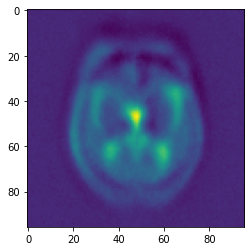

In [ ]:
plt.imshow(rec_bAE[0].squeeze(0).detach().cpu().numpy())

In [ ]:
rec_rAE = model_reg(batch_x).view(batch_x.shape)


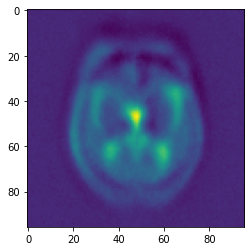

In [ ]:
plt.imshow(rec_rAE[0].squeeze(0).detach().cpu().numpy())